## Importo las librerias básicas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Instalo e importo las librerías necesarias para traducir las reseñas al ingles

In [ ]:
pip install --upgrade googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
import googletrans

In [ ]:
# Funcion para traducir la columna 'Review Text' y crear una nueva con la traducción, 'review_english'


def translate_column(df, column_name):
    translator = googletrans.Translator()
    df['review_english'] = ''
    for index, row in df.iterrows():
        # Translate the text.
        translated_text = translator.translate(row[column_name], dest='en')
        # Add the translated text to the new column.
        df.loc[index, 'review_english'] = translated_text.text
    return df

# Translate the 'Review Text' column of df_reseñas.
df_reseñas = translate_column(df_reseñas, 'Review Text')


In [21]:
# Lee el dataset
df_reseñas = pd.read_csv('data_traducida.csv')

In [22]:
df_reseñas

,Review Text,review_english,User Name
0,I cannot say enough good things about this car...,I cannot say enough good things about this car...,Julia S
1,Great service and easy to organize. Received ...,Great service and easy to organize. Received ...,Lilitreamont
2,We have used them 6 times this past year for m...,We have used them 6 times this past year for m...,BobnLaurie
3,"Great, Professional Drivers. They were early ...","Great, Professional Drivers. They were early ...",mld661
4,Great communication and service. Someone answe...,Great communication and service. Someone answe...,Audrey S
...,...,...,...
445,Excelente todo; la atencion pre-viaje - el ase...,Excellent everything;Pre -Viaje ATTENTION - Th...,Manuel P
446,"Puntual, excelente servicio y atención en todo...","Punctual, excellent service and attention in a...",Valeria345
447,La mejor manera de llegar a Nueva York. El tra...,The best way to get to New York.The journey wa...,Lizardo P
448,"Re linda energía, eficaz, muy atentos y puntua...","Re beautiful energy, effective, very attentive...",Emiliano V


## En el modelo de ML, vamos a utilizar un algoritmo de clasificacion supervisada, por ello, luego de leer varias reseñas, creo las categorías con las etiquetas que mejor se ajustan a los datos

In [23]:
# Definir la función para categorizar reseñas

def categorizar_reseñas(review_text):
    # Convertir el texto a minúsculas para facilitar la comparación
    review_text = review_text.lower()

    # Categoría 1: Recomendación por buen servicio del conductor
    if any(word in review_text for word in ['friendly', 'prompt', 'arrived on time', 'professional', 'informed',
                                             'attentive', 'excellence', 'attention', 'arrived early', 'organized',
                                               'helpful', 'support', 'competent', 'serious', 'punctual',
                                                 'provide fast', 'arrive on time']):
        return "Recomendación por buen servicio del conductor"
    
    # Categoría 2: Recomendación por buen estado del vehículo
    elif any(word in review_text for word in ['clean', 'immaculate', 'maintained', 'impeccable', 'quiet', 
                                              'well maintained']):
        return "Recomendación por buen estado del vehículo"
    
    # Categoría 3: Queja por conductor
    elif any(word in review_text for word in ['late', 'had a bad attitude', 'thing were wrong', 'reckless',
                                               'Unprofessional', 'not punctual']):
        return "Queja por conductor"
    
    # Categoría 4: Queja por vehículo
    elif any(word in review_text for word in ['dirty', 'poor condition', 'noisy', 'bad condition', 'uncomfortable']):
        return "Queja por vehículo"
    
    # Si no se encuentra ninguna categoría específica, se devuelve "Recomendacion General"
    else:
        return "Recomendacion General"

# Aplicar la función a la columna 'review_english' y crear una nueva columna llamada 'category'
df_reseñas['category'] = df_reseñas['review_english'].apply(categorizar_reseñas)

# Verificar el DataFrame resultante
df_reseñas.head()



,Review Text,review_english,User Name,category
0,I cannot say enough good things about this car...,I cannot say enough good things about this car...,Julia S,Recomendación por buen servicio del conductor
1,Great service and easy to organize. Received ...,Great service and easy to organize. Received ...,Lilitreamont,Recomendación por buen servicio del conductor
2,We have used them 6 times this past year for m...,We have used them 6 times this past year for m...,BobnLaurie,Recomendacion General
3,"Great, Professional Drivers. They were early ...","Great, Professional Drivers. They were early ...",mld661,Recomendación por buen servicio del conductor
4,Great communication and service. Someone answe...,Great communication and service. Someone answe...,Audrey S,Recomendación por buen servicio del conductor


In [18]:
# Calcular la cantidad de cada valor único en la columna 'category'
conteo_categorias = df_reseñas['category'].value_counts()

# Imprimir los valores diferentes de 'category' y su cantidad
print("Valores diferentes de 'category' y su cantidad:")
for categoria, cantidad in conteo_categorias.items():
    print(f"{categoria}: {cantidad}")


Valores diferentes de 'category' y su cantidad:
Recomendación por buen servicio del conductor: 227
Recomendacion General: 165
Recomendación por buen estado del vehículo: 37
Queja por conductor: 21


Podemos observar que la base de datos esta desbalanceada, lo que es probable afecte la precision del modelo. De todas formas vamos a probar el modelo con la data de origen y luego con alguna tecnica para optimizarlo, para compararlos.
Por otro lado el modelo se va a quedar con las 4 categorias que se han detectado, dejando la posibilidad de sumar nuevas categorías a medida que se alimente la base de datos.

## Importo la libreria necesaria para aplicar el modelo de ML DecisionTreeClassifier

#### Antes probe con otros modelos, pero este es el que mejor resultado arrojo, tratandose de un caso de small data

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Descargar recursos de NLTK
nltk.download('stopwords')

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Preprocesamiento de datos:Tokenizacion, Stop Words, Vectorizacion

##### Eliminamos palabras de paro en inglés del texto de las reseñas.
##### Convertimos el texto de las reseñas en una representación numérica utilizando el esquema TF-IDF.
##### En el código proporcionado se utiliza el TfidfVectorizer de scikit-learn para convertir el texto de las reseñas en una matriz de características TF-IDF.
##### El TfidfVectorizer realiza la tokenización automáticamente como parte de su proceso interno.

In [17]:
# Preprocesamiento de texto y vectorización
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_reseñas['review_english'])
y = df_reseñas['category']

# División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo de árbol de decisión
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = tree_classifier.predict(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))

                                               precision    recall  f1-score   support

                          Queja por conductor       1.00      0.67      0.80         3
                        Recomendacion General       0.77      0.79      0.78        29
   Recomendación por buen estado del vehículo       0.67      0.67      0.67         6
Recomendación por buen servicio del conductor       0.87      0.87      0.87        52

                                     accuracy                           0.82        90
                                    macro avg       0.82      0.75      0.78        90
                                 weighted avg       0.82      0.82      0.82        90



#### Como la base de datos esta desbalanceada, realizaré Oversampling para aumentar las categorias minoritarias, usando  SMOTE (Synthetic Minority Oversampling Technique).

In [25]:
pip install imbalanced-learn

   ---------------------------------------- 0.0/257.7 kB ? eta -:--:--
   --------- ------------------------------ 61.4/257.7 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------  256.0/257.7 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 257.7/257.7 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
from imblearn.over_sampling import SMOTE

# Preprocesamiento de texto y vectorización
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_reseñas['review_english'])
y = df_reseñas['category']

# Aplicación de SMOTE para balancear la base de datos
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenamiento del modelo de árbol de decisión
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = tree_classifier.predict(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))


                                               precision    recall  f1-score   support

                          Queja por conductor       0.95      0.97      0.96        39
                        Recomendacion General       0.89      0.94      0.92        52
   Recomendación por buen estado del vehículo       0.97      1.00      0.99        37
Recomendación por buen servicio del conductor       0.94      0.85      0.89        54

                                     accuracy                           0.93       182
                                    macro avg       0.94      0.94      0.94       182
                                 weighted avg       0.93      0.93      0.93       182



In [29]:
# Uso del modelo para predecir nuevas reseñas
new_reviews = [
    "The taxi driver was very friendly and arrived on time. Excellent service!",
    "I highly recommend this service. The car was clean.",
    "The driver was reckless and arrived late. I would not use this service again."
]

# Vectorización de las nuevas reseñas utilizando el vectorizador
X_new = vectorizer.transform(new_reviews)

# Predicciones utilizando el modelo de árbol de decisión
predictions = tree_classifier.predict(X_new)

# Imprimir las predicciones para las nuevas reseñas
print("Predicciones para nuevas reseñas:")
for review, prediction in zip(new_reviews, predictions):
    print(f"{review} -> {prediction}")


Predicciones para nuevas reseñas:
The taxi driver was very friendly and arrived on time. Excellent service! -> Recomendación por buen servicio del conductor
I highly recommend this service. The car was clean. -> Recomendación por buen estado del vehículo
The driver was reckless and arrived late. I would not use this service again. -> Queja por conductor


# También aplicamos Analisis de Sentimiento a las reseñas

In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargo el léxico necesario para SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Creo una instancia de SentimentIntensityAnalyzer, que se utilizará para calcular la puntuación de polaridad de los textos.
sia = SentimentIntensityAnalyzer()

# Función para asignar etiquetas de sentimiento
def etiquetar_sentimiento(texto):
    if pd.notnull(texto):  # primero verifica si el valor no es nulo
        score = sia.polarity_scores(texto)['compound']
        #sia es la instancia creada al principio 
        #sia.polarity_scores(texto): Llama al método polarity_scores de SentimentIntensityAnalyzer y le pasa el texto como argumento. 
        # Este método devuelve un diccionario con varias puntuaciones, incluyendo la puntuación de compuesto.
        #['compound']: Accede al valor correspondiente a la clave 'compound' en el diccionario devuelto por polarity_scores. 
        # el valor obtenido es asignado a la variable score



        # Asigno etiquetas (0, 1, 2) a la puntuación de compuesto (score)
        if score >= 0.05:
            return 2  # Sentimiento positivo
        elif -0.05 < score < 0.05:
            return 1  # Sentimiento neutro
        else:
            return 0  # Sentimiento negativo
    else:
        return 1  # cuando es nulo retorna 1
    
# Aplico la función a la columna 'review_english' y creo con los resultados una nueva columna 'sentimiento'
df_reseñas['sentiment'] = df_reseñas['review_english'].apply(etiquetar_sentimiento)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
#guardo el dataset con las columnas category y sentiment

df_reseñas.to_csv('reviews.csv',index=False)

In [2]:
# Lee el dataset
df_reseñas = pd.read_csv('reviews.csv')

df_reseñas

,Review Text,review_english,User Name,category,sentiment
0,I cannot say enough good things about this car...,I cannot say enough good things about this car...,Julia S,Recomendación por buen servicio del conductor,2
1,Great service and easy to organize. Received ...,Great service and easy to organize. Received ...,Lilitreamont,Recomendación por buen servicio del conductor,2
2,We have used them 6 times this past year for m...,We have used them 6 times this past year for m...,BobnLaurie,Recomendacion General,2
3,"Great, Professional Drivers. They were early ...","Great, Professional Drivers. They were early ...",mld661,Recomendación por buen servicio del conductor,2
4,Great communication and service. Someone answe...,Great communication and service. Someone answe...,Audrey S,Recomendación por buen servicio del conductor,2
...,...,...,...,...,...
445,Excelente todo; la atencion pre-viaje - el ase...,Excellent everything;Pre -Viaje ATTENTION - Th...,Manuel P,Recomendación por buen servicio del conductor,2
446,"Puntual, excelente servicio y atención en todo...","Punctual, excellent service and attention in a...",Valeria345,Recomendación por buen servicio del conductor,2
447,La mejor manera de llegar a Nueva York. El tra...,The best way to get to New York.The journey wa...,Lizardo P,Recomendación por buen servicio del conductor,2
448,"Re linda energía, eficaz, muy atentos y puntua...","Re beautiful energy, effective, very attentive...",Emiliano V,Recomendación por buen servicio del conductor,2


## EDA de las reseñas

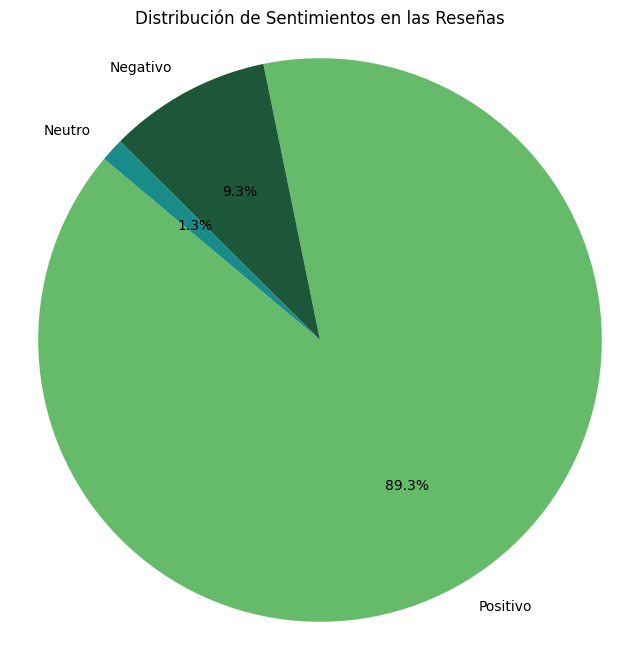

In [3]:

# Mapear los valores de la columna 'sentiment' a etiquetas deseadas
etiquetas_sentimiento = {2: 'Positivo', 1: 'Neutro', 0: 'Negativo'}

# Reemplazar los valores en la columna 'sentiment' con las etiquetas deseadas
df_reseñas['sentiment_etiqueta'] = df_reseñas['sentiment'].map(etiquetas_sentimiento)

# Define los colores
colores = ['#66bb6a', '#1c5739', '#198c89']

# Calcular la cantidad de cada valor único en la columna 'sentiment'
conteo_sentimientos = df_reseñas['sentiment_etiqueta'].value_counts()

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(conteo_sentimientos, labels=conteo_sentimientos.index, autopct='%1.1f%%', startangle=140, colors= colores)
plt.title('Distribución de Sentimientos en las Reseñas')
plt.axis('equal')

# Guardar la imagen
plt.savefig('reseñas_sentimientos.png')

# Mostrar el gráfico
plt.show()



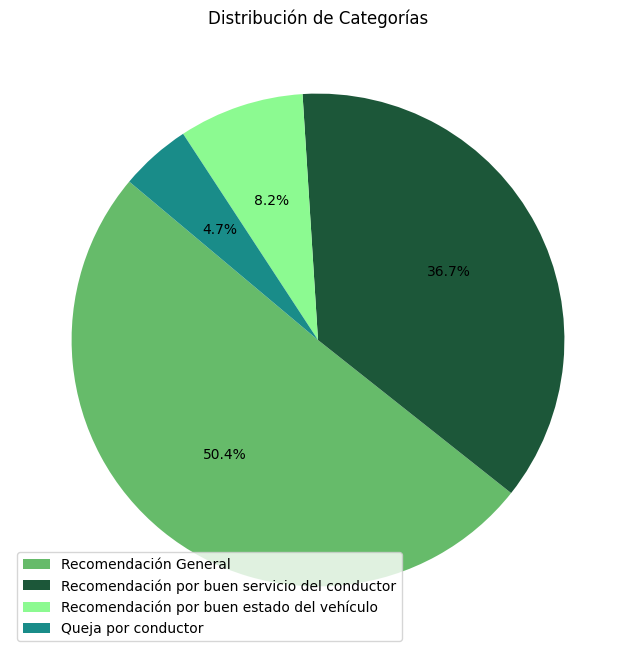

In [4]:
# Calcular el recuento de valores únicos en la columna 'category'
conteo_categorias = df_reseñas['category'].value_counts()

# Etiquetas y títulos personalizados para las categorías
etiquetas = ['Recomendación General', 
             'Recomendación por buen servicio del conductor', 
             'Recomendación por buen estado del vehículo', 
             'Queja por conductor'
             ]
# Define los colores
colores = ['#66bb6a','#1c5739', '#8cfa91','#198c89']
# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
# Dibujar la torta con porcentajes pero sin etiquetas
porciento, labels, _ = plt.pie(conteo_categorias, autopct='%1.1f%%', startangle=140, colors=colores)
# Agregar las etiquetas al costado
plt.legend(porciento, etiquetas, loc="best")
# Título del gráfico
plt.title('Distribución de Categorías')

# Guardar la imagen
plt.savefig('reseñas_categorias.png')

# Mostrar el gráfico
plt.show()

